# Testing Notebook

This notebook provides some test code/ experimentation for the implementation of centrality analysis from the paper *On the Concept of Depth from Functional Data*

Warning: the work here is very rough.

The following function produces all subsequences of length `l` from the list `s`. 

In [1]:
from itertools import combinations 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

def subsequences(s, l):
    '''Returns a list of all possible subsequences of the given length from the given input list
    Parameters:
    -------------
    s: List to enumerate
    l: length of subsequences to find'''
    return sorted(set([i for i in combinations(s, l)]))

We now test the standard definition of $V(x_{i_1}, ... ,x_{i_j})$ containment in $\mathbb{R}^2$ 

In [6]:
def _r2_containment(data: pd.DataFrame, curve: pd.Series) -> float:
    '''Produces \lambda_r with the given input data, using the standard ordering on R as the definition for containment.
    Parameters:
    ----------

    data: Array of real-valued functions that define our band in R^2
    curve: Function to check containment on 

    Returns:
    ----------
    0 if the function is not contained in the curve, 1 if it is
    '''

    # Generate discrete band 
    y_range = []
    for time_index in data.columns:
        y_range.append([data[time_index].min(), data[time_index].max()])

    # Check if each value in the curve is entirely contained within the band 
    for index, val in enumerate(curve):
        # If any value is not, then break out. This is strict containment!
        if not (y_range[index][0] <= val <= y_range[index][1]):
            return 0

    return 1


And define a fake dataset to do so

In [8]:
df = pd.DataFrame([
    [1, 2, 3, 4],
    [2, 2, 4, 5],
    [3, 0, 4, 6],
    [2, 2, 2, 7],
    [9, 10, 11, 11]
], columns=list('1234'))


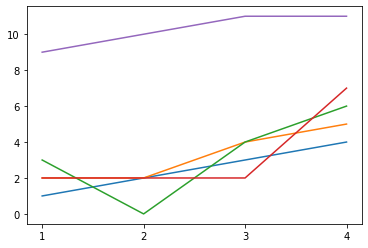

In [9]:
plt.plot(df.T);

In [17]:
from scipy.special import binom, comb

def _band_depth(data: pd.DataFrame, curve: int, containment='r2', J=2) -> float:
    """Calculates each band depth for a given curve in the dataset. Meant for J > 2, as J=2 has a closed solution. This function is wrapped in banddepth()
    
    Parameters:
    ----------
    data: An n x p matrix where our rows come from R. Each observation should define a curve, in the functional sense. 

    curve: The particular function we would like to calculate band curve for. Given as a row of our original DataFrame. 

    containment: function that defines containment for the particular data. For example, in R^2 this would be a discrete subset 

    J=2: Defaulted to 2. 
    """
    
    # Initialize band depth, n
    band_depth = 0
    n = len(data)
    
    # Select our containment definition if it is in our pre-defined list
    if containment == 'r2':
        cdef = _r2_containment
    elif containment == 'r2_enum':
        cdef = _r2_enum_containment
    elif containment == 'simplex':
        cdef = _simplex_containment
    else:
        # TODO: Allow user to pass in custom definition of containment
        raise ValueError('Error: Unknown or unspecified definition of containment')

    # Reset index of our data 
    data = data.reset_index(drop=True)

    # Grab the data for our curve so numerical slicing is guaranteed to work
    curve_data = data.loc[curve, :]

    # Drop the curve (we don't want it used in defining our band/generalized band -- doesn't make sense)
    data = data.drop(curve)

    # Define our index to be the index of our dataset, excluding the last row (for indexing reasons)
    idx = list(data.index)
    
    # iterate from 2,...,J
    for j in range(2, J + 1):
        
        # Initialize S_n^(j) as defined in the paper
        S_nj = 0

        # Get a list of all possible subsequences of samples (rows)
        subseq = subsequences(idx, j)

        # Get generalized containment for this value of J=j
        for sequence in subseq:
            subseq_df = data.loc[list(sequence), :]

            S_nj += cdef(data=subseq_df, curve=curve_data)

        band_depth += S_nj / binom(n, j)
    
    return band_depth

for row in range(0, len(df)):
    print('Band depth for row {} is {}'.format(row, _band_depth(df, curve=row, J=2)))
    

Band depth for row 0 is 0.0
Band depth for row 1 is 0.2
Band depth for row 2 is 0.0
Band depth for row 3 is 0.0
Band depth for row 4 is 0.0


In [27]:
def j2_depth(data: pd.DataFrame, method='BD2'):
    n, p = data.shape
    rv = np.argsort(data, axis=0)
    rmat = np.argsort(rv, axis=0) + 1

    # This code is an explicit solution for J=2 and therefore cannot be generalized. 
    # band depth
    def _fbd2():
        down = np.min(rmat, axis=1) - 1
        up = n - np.max(rmat, axis=1)
        return (up * down + n - 1) / comb(n, 2)

    # modified band depth
    def _fmbd():
        down = rmat - 1
        up = n - rmat
        return ((np.sum(up * down, axis=1) / p) + n - 1) / comb(n, 2)

    if method == 'BD2':
        depth = _fbd2()
    elif method == 'MBD':
        depth = _fmbd()
    else:
        raise ValueError("Unknown input value for parameter `method`.")

    return depth
    
j2_depth(df)

0    0.4
1    0.6
2    0.4
3    0.4
4    0.4
dtype: float64

We now test the closed form solution

In [ ]:
from scipy.special import comb

def banddepthclosed(data: pd.DataFrame, method='MBD'):
    n, p = data.shape
    rv = np.argsort(data, axis=0)
    rmat = np.argsort(rv, axis=0) + 1

    # This code is an explicit solution for J=2 and therefore cannot be generalized. 
    # band depth
    def _fbd2():
        down = np.min(rmat, axis=1) - 1
        up = n - np.max(rmat, axis=1)
        return (up * down + n - 1) / comb(n, 2)

    # modified band depth
    def _fmbd():
        down = rmat - 1
        up = n - rmat
        return ((np.sum(up * down, axis=1) / p) + n - 1) / comb(n, 2)

    if method == 'BD2':
        depth = _fbd2()
    elif method == 'MBD':
        depth = _fmbd()
    else:
        raise ValueError("Unknown input value for parameter `method`.")

    return depth

banddepthclosed(df)

We now redefine our band depth to use a modified definition for containment

In [25]:
def _r2_containment(data: pd.DataFrame, curve: pd.Series) -> int:
    # Generate discrete band
    flag = 1
    y_range = []
    for time_index in data.columns:
        y_range.append([data[time_index].min(), data[time_index].max()])

    # Check if each value in the curve is entirely contained within the band 
    for idx, val in enumerate(curve):
        if not (y_range[idx][0] <= val <= y_range[idx][1]):
            flag = 0

    return int(flag==1)
    
def _band_depth(data: pd.DataFrame, curve: int, containment='r2', J=2) -> float:
    # Initialize band depth, n
    band_depth = 0
    n = len(data)
    
    # Select our containment definition if it is in our pre-defined list 
    if containment == 'r2':
        containment = _r2_containment
    # todo
    else:
        pass
    # Reset index of our data 
    data = data.reset_index(drop=True)

    # Grab the data for our curve so numerical slicing is guaranteed to work
    curve_data = data.loc[curve, :]

    # Drop the curve (we don't want it used in defining our band/generalized band -- doesn't make sense)
    data = data.drop(curve)

    # Define our index to be the index of our dataset, excluding the last row (for indexing reasons)
    idx = list(data.index)
    
    # iterate from 2,...,J
    for j in range(2, J + 1):
        
        # Initialize S_n^(j) as defined in the paper
        S_nj = 0

        # Get a list of all possible subsequences of samples (rows)
        subseq = subsequences(idx, j)

        # Get generalized containment for this value of J=j
        for sequence in subseq:
            subseq_df = data.loc[list(sequence), :]

            S_nj += containment(data=subseq_df, curve=curve_data)

        band_depth += (1 / binom(n, j)) * S_nj
    
    return band_depth

# for row in range(0, len(df)):
#     print('Band depth for row {} is {}'.format(row, _band_depth(df, curve=row, J=2)))


In [ ]:
def _band_depth_est(data: pd.DataFrame, curve: int, K: int, containment='r2', J=2) -> float:
    '''Estimates the band depth by
    
    1. Splitting the n sample curves into K blocks of size ~n/K
    2. Computing band depth with respect to each block
    3. Returning the average of these depths
    
    '''
    
    # Block size
    sample = df.shape[0] // K
    
    # Estimation array
    depths = []
    
    # Copy curve data so it isn't lost when DataFrame is sampled from
    curve_data = curve
    
    # Compute band depth for all K - 1 blocks
    for k in range(K - 1):
        t = data.sample(n=sample, replace=False)
        data = data.drop(t.index)
        
        depths.append(_band_depth(data=data, curve=curve_data, containment=containment, J=J))
    
    # Compute band depth with "whatever's left", will be a slightly larger block but ok. 
    depths.append(_band_depth(data=data, curve=curve, containment=containment, J=J))
    
    return np.mean(depths)


for row in range(0, len(df)):
    print('Band depth for row {} is {}'.format(row, _band_depth_est(data=df, curve=row, K=20, J=2)))


In [30]:
index = ['0:00', '0:50']
df1 = pd.DataFrame([
    [1,2,3],
    [4,5,6]
], columns=list('abc'), index=index)

df2 = pd.DataFrame([
    [3,2,1],
    [5,4,3]
], columns=list('abc'), index=index)

df3 = pd.DataFrame([
    [1,2,3],
    [9,10,1]
], columns=list('abc'), index=index)

display(df1)
display(df2)
display(df3)

,a,b,c
0:00,1,2,3
0:50,4,5,6


,a,b,c
0:00,3,2,1
0:50,5,4,3


,a,b,c
0:00,1,2,3
0:50,9,10,1
